<a href="https://colab.research.google.com/github/bilalmashooq/ML_Practice/blob/master/optimized_LFW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available. Please enable GPU in Runtime > Change runtime type.")


GPU is available.


In [14]:
# Authenticate with Google Drive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import standard machine learning and data science modules
import numpy as np
import pandas as pd
import random
import os
import shutil
from tqdm import tqdm
from glob import glob
import math
from functools import partial

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.spatial import distance
from sklearn.metrics import accuracy_score


# Import image processing and visualization libraries
from PIL import Image
from IPython.display import display
from matplotlib.image import pil_to_array, imread
from matplotlib import pyplot as plt

# Import Keras modules
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory, array_to_img, img_to_array, load_img
from keras.layers import RandomZoom
from keras import layers
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input, Lambda, AveragePooling2D, Activation, PReLU, ReLU
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, TerminateOnNaN, EarlyStopping
from keras.optimizers import SGD, Adam
import keras.backend as K

# Miscellaneous settings
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
random.seed(42)
tqdm.pandas()
os.environ["KERAS_BACKEND"] = "tensorflow"

# Check Keras version
print(f"Keras version: {keras.__version__}")


Keras version: 3.5.0


In [15]:
# Google Drive upload/download helpers
def drive_upload_file(full_filename):
    filename = os.path.basename(full_filename)
    file_to_upload = drive.CreateFile({'title': filename})
    file_to_upload.SetContentFile(full_filename)
    file_to_upload.Upload()

def drive_download_file(file_id, local_path='./'):
    # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.FetchMetadata()
    fn = downloaded.metadata.get('originalFilename')
    full_fn = os.path.join(local_path, fn)
    downloaded.GetContentFile(full_fn)
    return full_fn

# Dataset reading helpers
def filter_df(df, min_images_count=0):
    df = df.sort_values('images', ascending=False)
    return df[df.images >= min_images_count]

# Undo ImageNet preprocessing to show images from batch generator
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)  # RGB
de_preproc = lambda x: np.clip((x[..., ::-1] + vgg_mean) / 255., 0, 1)

# Visualization helpers
img_root_dir = 'input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
equal_apriori = 0.5
num_thresholds = 100
thresholds = [i / num_thresholds for i in range(num_thresholds)]

def plot_scores(imposter, genuine):
    """ Plot the scores of the genuine and imposters """
    plt.hist(imposter, facecolor='g', alpha=0.50, label='Imposter')
    plt.hist(genuine, facecolor='y', alpha=0.50, label='Genuine')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

def calculate_cost(imposter, genuine):
    """ Calculates FAR and FRR for different thresholds """
    far = []
    frr = []
    for t in thresholds:
        FP = np.sum(imposter >= t)
        TN = np.sum(imposter < t)
        TP = np.sum(genuine >= t)
        FN = np.sum(genuine < t)
        far_current = FP / len(imposter)
        frr_current = FN / len(genuine)
        far.append(far_current)
        frr.append(frr_current)
    return far, frr

def plot_DET_with_EER(far, frr, far_optimum, frr_optimum):
    """ Plots DET curve with EER point """
    plt.plot(far, frr, linestyle="--", linewidth=2, label="DET Curve")
    plt.plot(far_optimum, frr_optimum, "ro", label="EER Point")
    plt.plot([1.0, 0.0], [0.0, 1.0], 'k--', label='EER Line')
    plt.xlabel('False Accept Rate (FAR)')
    plt.ylabel('False Reject Rate (FRR)')
    plt.title('DET Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_FAR_vs_FRR(far, frr):
    """ Plots FAR and FRR against thresholds """
    plt.plot(thresholds, far, 'g-', label='FAR curve')
    plt.plot(thresholds, frr, 'b-', label='FRR curve')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('FAR and FRR vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

def find_EER(far, frr):
    """ Finds the Equal Error Rate (EER) """
    far = np.array(far)
    frr = np.array(frr)
    delta = np.abs(far - frr)
    idx = np.argmin(delta)
    return far[idx], frr[idx], thresholds[idx]

def plot_legends():
    legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('#ffffff')

def show_plot():
    plt.show()

def extract_template(image_paths, model, target_size=(224, 224), batch_size=32):
    """
    Extract image template from a filename list using a Keras model and tf.data.Dataset.
    """
    def preprocess_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (256, 256))
        img = zoom_image(img)
        return img

    zoom_image = keras.Sequential([
        keras.layers.RandomZoom((-0.5, -0.5)),
        keras.layers.Resizing(target_size[0], target_size[1]),
        keras.layers.Rescaling(scale=1./255)
    ])
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    predictions = model.predict(dataset)
    return predictions.tolist()

def name_to_image_path(root_dir, name, image_num):
    return f'{root_dir}/{name}/{name}_{image_num:04d}.jpg'

def evaluate_model(model, pairs_file='./input/lfw-dataset/course-pairsDevTest.csv'):
    """
    Evaluates the model by computing EER, FAR, FRR, and accuracy.

    Args:
        model: Trained Keras model.
        pairs_file: Path to the CSV file containing image pairs.

    Returns:
        test_pairs: DataFrame with evaluation results.
        eer_info: Dictionary containing EER details.
        far: List of False Accept Rates across thresholds.
        frr: List of False Reject Rates across thresholds.
    """
    # Extract embeddings from the 'face_embedding' layer
    embedding_out = model.get_layer('face_embedding').output
    template_extrator = Model(inputs=model.input, outputs=embedding_out)

    # Read the pairs CSV file
    print('Preparing stats from dev set')
    test_pairs = pd.read_csv(pairs_file)

    # Generate image paths
    test_pairs['img_fn1'] = test_pairs.apply(
        lambda row: name_to_image_path(img_root_dir, row['name1'], row['imagenum1']),
        axis=1
    )
    test_pairs['img_fn2'] = test_pairs.apply(
        lambda row: name_to_image_path(img_root_dir, row['name2'], row['imagenum2']),
        axis=1
    )

    # Extract templates for both images in each pair
    test_pairs['template1'] = extract_template(
        test_pairs['img_fn1'].tolist(),
        template_extrator,
        target_size
    )
    test_pairs['template2'] = extract_template(
        test_pairs['img_fn2'].tolist(),
        template_extrator,
        target_size
    )

    # Compute cosine distance between embeddings
    test_pairs['cos_distance'] = test_pairs.apply(
        lambda row: distance.cosine(row['template1'], row['template2']) / 2.,  # Rescaled to (0,1)
        axis=1
    )

    # Separate genuine and imposter scores
    match_scores = test_pairs[test_pairs.match_pair == 1]['cos_distance']
    mismatch_scores = test_pairs[test_pairs.match_pair == 0]['cos_distance']

    # Calculate FAR and FRR
    far, frr = calculate_cost(mismatch_scores, match_scores)
    far_optimum, frr_optimum, err_threshold = find_EER(far, frr)

    # Plot evaluation metrics
    plot_scores(mismatch_scores, match_scores)
    plot_DET_with_EER(far, frr, far_optimum, frr_optimum)
    plot_FAR_vs_FRR(far, frr)

    print(f'EER at threshold: {err_threshold}')

    # Calculate predictions based on EER threshold
    test_pairs['pred_match_pair'] = (test_pairs['cos_distance'] < err_threshold).astype(int)

    # Compute accuracy
    accuracy = accuracy_score(test_pairs.match_pair.values, test_pairs.pred_match_pair.values)
    print(f'At threshold {err_threshold} accuracy score is {accuracy:.4f}')

    # Compile evaluation info
    eer_info = {
        'far_optimum': far_optimum,
        'frr_optimum': frr_optimum,
        'err_threshold': err_threshold,
        'accuracy': accuracy
    }

    return test_pairs, eer_info, far, frr


In [4]:
# Create necessary directories
!mkdir -p input/lfw-dataset

# Download LFW dataset (Replace 'file_id' with your actual file ID)
file_id = '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD'  # Example ID
drive_download_file(file_id, local_path='./input/')

# Unpack zip files
!7z x ./input/lfw-dataset.zip -o./input/lfw-dataset -aoa
!7z x ./input/lfw-dataset/lfw-deepfunneled.zip -o./input/lfw-dataset/lfw-deepfunneled -aoa

# Clean temporary files
!rm -r ./input/lfw-dataset/lfw-deepfunneled/__MACOSX/ ./input/lfw-dataset/__MACOSX/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./input/                  1 file, 116495068 bytes (112 MiB)

Extracting archive: ./input/lfw-dataset.zip
--
Path = ./input/lfw-dataset.zip
Type = zip
Physical Size = 116495068

  0%     16% 25 - lfw-deepfunneled.zip                               31% 25 - lfw-deepfunneled.zip                               48% 25 - lfw-deepfunneled.zip                               62% 25 - lfw-deepfunneled.zip                               75% 25 - lfw-deepfunneled.zip

Number of classes with >= 20 images: 46
Training samples: 1896, Validation samples: 474
Created directories: 
input/lfw-train-test-split/train/, 
input/lfw-train-test-split/validation/


Copying Validation Images: 100%|██████████| 474/474 [00:00<00:00, 741.06it/s]


input/lfw-train-test-split/train/George_W_Bush/George_W_Bush_0338.jpg 250 250


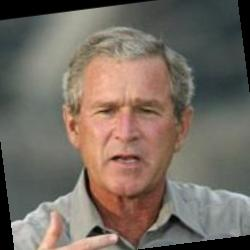

input/lfw-train-test-split/train/Alejandro_Toledo/Alejandro_Toledo_0027.jpg 250 250


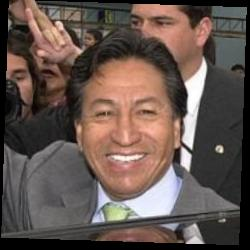

input/lfw-train-test-split/train/Jose_Maria_Aznar/Jose_Maria_Aznar_0002.jpg 250 250


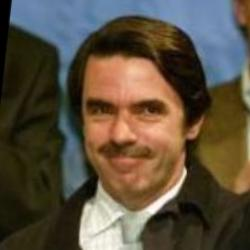

In [5]:
# Define minimum images per person
min_images_count = 20

# Load and filter training labels
df_train = filter_df(pd.read_csv('./input/lfw-dataset/peopleDevTrain.csv'), min_images_count=min_images_count)
print(f"Number of classes with >= {min_images_count} images: {len(df_train)}")

# Prepare list of all training images
all_train = []
for name in df_train.name.values:
    imgs_for_name = glob(f'./input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name}/*.jpg')
    all_train += [{'name': name, 'filename': fn} for fn in imgs_for_name]

# Convert to DataFrame
df_train = pd.DataFrame(all_train)

# Split into training and validation sets (80-20 split)
df_train, df_val = train_test_split(df_train, train_size=0.8, stratify=df_train.name.values, random_state=42)
print(f"Training samples: {len(df_train)}, Validation samples: {len(df_val)}")

# Create directories structure
root_path = 'input/lfw-train-test-split'
weights_path = './weights'
logs_path = f'{root_path}/logs'

os.makedirs(weights_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)

train_path = f'{root_path}/train/'
validation_path = f'{root_path}/validation/'

# Remove existing directories if any
shutil.rmtree(train_path, ignore_errors=True)
shutil.rmtree(validation_path, ignore_errors=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

# Create class-specific directories
for name in df_train.name.values:
    os.makedirs(os.path.join(train_path, name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, name), exist_ok=True)

print(f"Created directories: \n{train_path}, \n{validation_path}")

# Copy images to training directory
for i, row in tqdm(df_train.iterrows(), total=df_train.shape[0], desc="Copying Training Images"):
    shutil.copy(row['filename'], os.path.join(train_path, row['name']))

# Copy images to validation directory
for i, row in tqdm(df_val.iterrows(), total=df_val.shape[0], desc="Copying Validation Images"):
    shutil.copy(row['filename'], os.path.join(validation_path, row['name']))

# Display sample images
imgs_fn = glob(f'{train_path}/**/*.jpg', recursive=True)
for fn in np.random.choice(imgs_fn, size=3, replace=False):
    img = Image.open(fn)
    print(fn, img.height, img.width)
    display(img)


Found 1896 files belonging to 46 classes.
Found 474 files belonging to 46 classes.


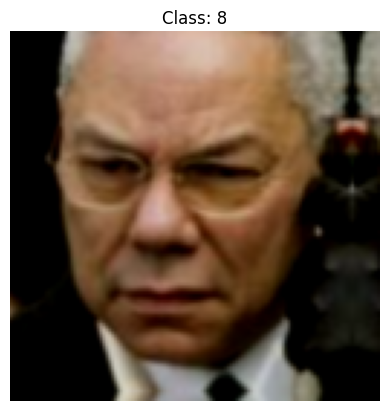

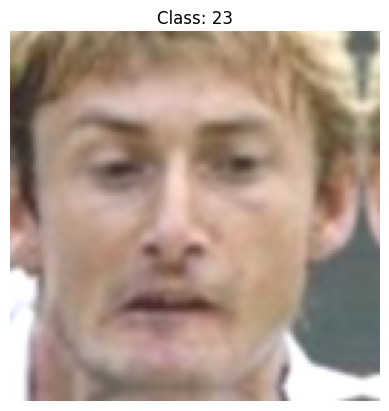

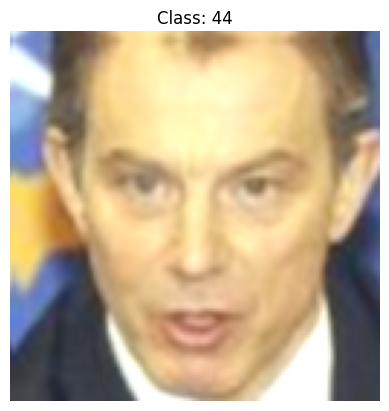

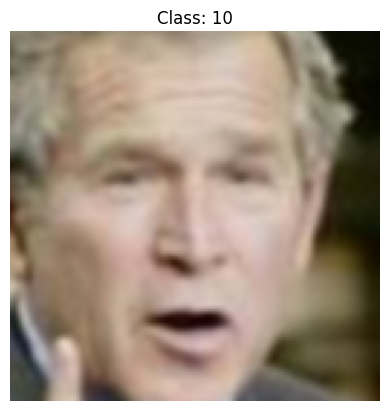

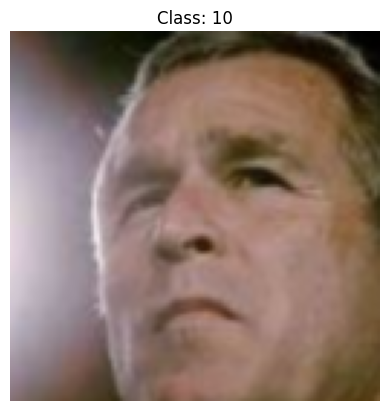

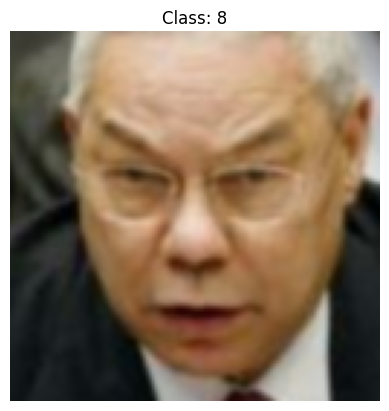

In [6]:
# Define batch size and target image size
batch_size = 64  # Optimized batch size
target_size = (128, 128)  # Optimized image size
n_count = 3  # Number of repetitions

# Define data augmentation for training
train_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.45, -0.55)),
    keras.layers.RandomFlip(mode="horizontal"),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.Resizing(target_size[0], target_size[1]),
    keras.layers.Rescaling(scale=1./255)
])

# Define data augmentation for validation (typically less aggressive)
valid_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.5, -0.5)),
    keras.layers.Resizing(target_size[0], target_size[1]),
    keras.layers.Rescaling(scale=1./255)
])

# Define preprocessing function
def preprocess(image, label, img_aug):
    image = img_aug(image)
    return image, label

# Create training dataset
train_dataset = keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(256, 256)  # Original image size before resizing
)

n_classes = len(train_dataset.class_names)
augment_train = partial(preprocess, img_aug=train_img_aug)

# Create training data generator
train_gen = train_dataset.map(augment_train, num_parallel_calls=AUTOTUNE).repeat(n_count).cache().shuffle(100).prefetch(AUTOTUNE)

# Create validation dataset
valid_dataset = keras.utils.image_dataset_from_directory(
    validation_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=64,  # Use same optimized batch size
    image_size=(256, 256)
)

augment_valid = partial(preprocess, img_aug=valid_img_aug)

# Create validation data generator
valid_gen = valid_dataset.map(augment_valid, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

# Visualize some augmented training images
batch_x, batch_y = next(iter(train_gen.take(1)))
for i in range(3):
    plt.imshow(batch_x[i].numpy())
    plt.title(f"Class: {np.argmax(batch_y[i].numpy())}")
    plt.axis('off')
    plt.show()

# Visualize some augmented validation images
batch_x_val, batch_y_val = next(iter(valid_gen.take(1)))
for i in range(3):
    plt.imshow(batch_x_val[i].numpy())
    plt.title(f"Class: {np.argmax(batch_y_val[i].numpy())}")
    plt.axis('off')
    plt.show()


In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Define Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [8]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization
from keras.optimizers import Adam

# Define Hyperparameters
embedding_size = 64        # Increased embedding size
dropout_rate = 0.3         # Increased dropout rate
nb_epochs = 20             # Number of epochs

# Define the Optimized Linear Regression Model
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)

x = Flatten()(input_layer)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(embedding_size, activation='relu', name='face_embedding')(x)
output_layer = Dense(n_classes, activation='softmax')(x)

model_lr_optimized = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=1e-4)  # Optimized learning rate
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model_lr_optimized.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model_lr_optimized.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,166,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ face_embedding (Dense)               │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 46)                  │           2,990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,317,102 (96.58 MB)

 Trainable params: 25,317,102 (96.58 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the Optimized Linear Regression Model
hist_lr_optimized = model_lr_optimized.fit(
    train_gen,
    epochs=nb_epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen)
)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.1277 - loss: 3.8891 - val_accuracy: 0.2278 - val_loss: 3.3663 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
17/90 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1795 - loss: 3.5213

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1952 - loss: 3.4841 - val_accuracy: 0.2236 - val_loss: 3.2833 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2173 - loss: 3.4003 - val_accuracy: 0.2468 - val_loss: 3.2580 - learning_rate: 1.0000e-04
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2090 - loss: 3.3344 - val_accuracy: 0.2553 - val_loss: 3.1995 - learning_rate: 1.0000e-04
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2204 - loss: 3.2953 - val_accuracy: 0.2511 - val_loss: 3.1586 - learning_rate: 1.0000e-04
Epoch 10/20
90/90 ━━━━━━━

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step


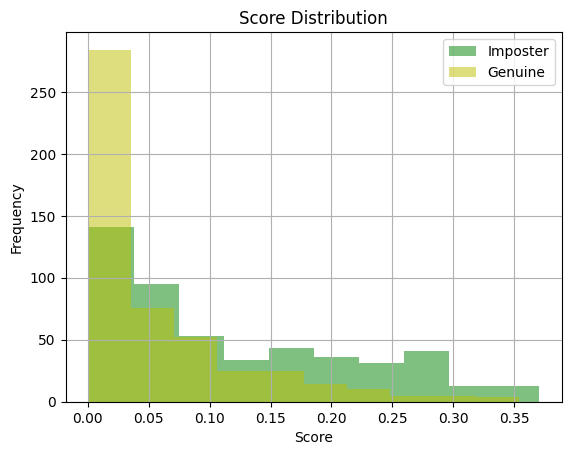

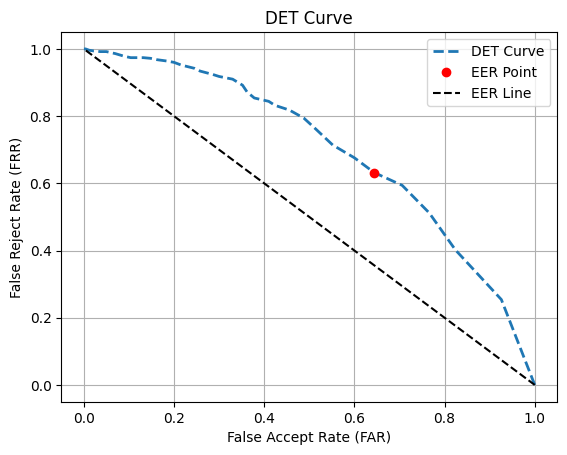

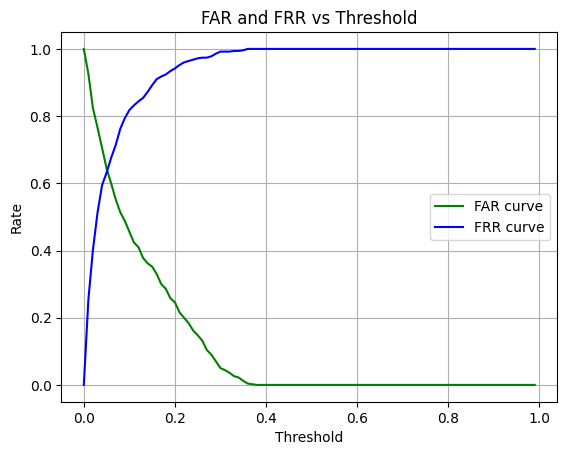

EER at threshold: 0.05
At threshold 0.05 accuracy score is 0.6380
EER at threshold: 0.05
At threshold 0.05 accuracy score is 0.6380


In [16]:
# Evaluate the Optimized Linear Regression Model
pairs_df_lr_opt, eer_info_lr_opt, far_lr_opt, frr_lr_opt = evaluate_model(model_lr_optimized)

print(f"EER at threshold: {eer_info_lr_opt['err_threshold']}")
print(f"At threshold {eer_info_lr_opt['err_threshold']} accuracy score is {eer_info_lr_opt['accuracy']:.4f}")


In [17]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization
from keras.optimizers import Adam

# Define Hyperparameters
embedding_size = 128        # Increased embedding size
dropout_rate = 0.3          # Increased dropout rate
nb_epochs = 30              # Increased number of epochs

# Define the Optimized DNN Model
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)

x = Flatten()(input_layer)
x = Dropout(dropout_rate)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(embedding_size, activation='relu', name='face_embedding')(x)
output_layer = Dense(n_classes, activation='softmax')(x)

model_dnn_optimized = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=1e-4)  # Optimized learning rate
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model_dnn_optimized.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model_dnn_optimized.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      12,583,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ face_embedding (Dense)               │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,706,862 (48.47 MB)

 Trainable params: 12,705,582 (48.47 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [18]:
# Train the Optimized DNN Model
hist_dnn_optimized = model_dnn_optimized.fit(
    train_gen,
    epochs=nb_epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen)
)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.0251 - loss: 4.2936 - val_accuracy: 0.2236 - val_loss: 3.5244 - learning_rate: 1.0000e-04
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
22/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0657 - loss: 3.8115

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0858 - loss: 3.7494 - val_accuracy: 0.1540 - val_loss: 3.5064 - learning_rate: 1.0000e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1663 - loss: 3.4754 - val_accuracy: 0.1392 - val_loss: 3.4379 - learning_rate: 1.0000e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2101 - loss: 3.2843 - val_accuracy: 0.2004 - val_loss: 3.1691 - learning_rate: 1.0000e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2190 - loss: 3.1669 - val_accuracy: 0.2658 - val_loss: 3.0485 - learning_rate: 1.0000e-04
Epoch 9: early stopping
Res

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step


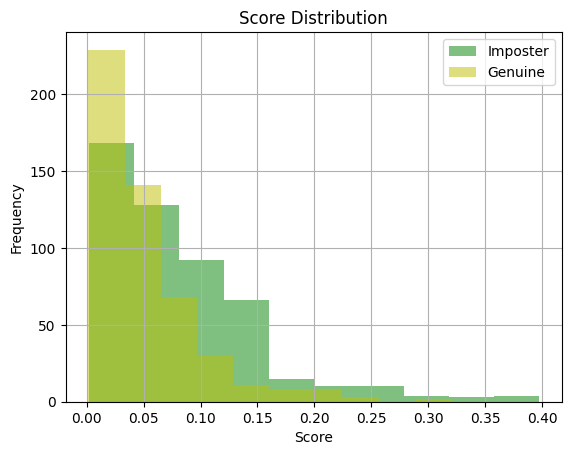

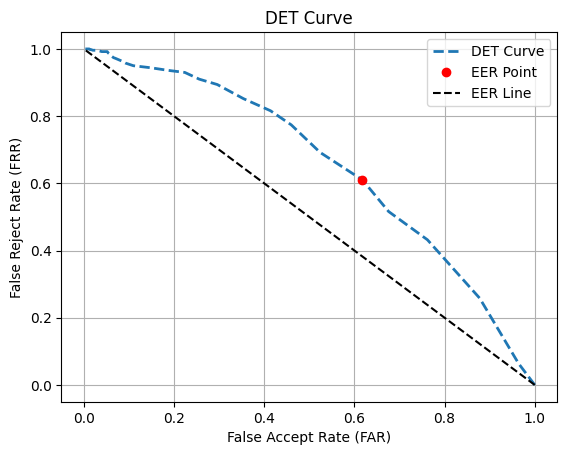

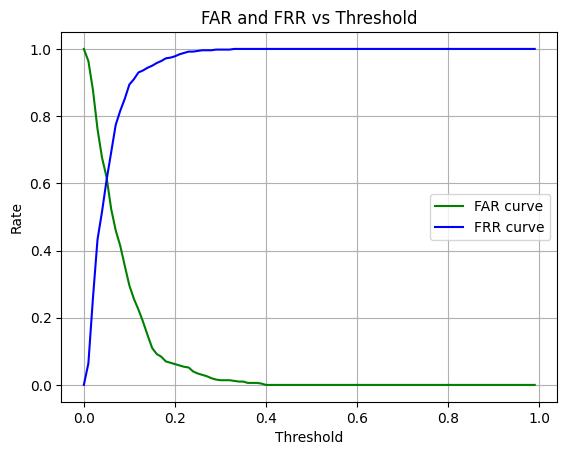

EER at threshold: 0.05
At threshold 0.05 accuracy score is 0.6140
EER at threshold: 0.05
At threshold 0.05 accuracy score is 0.6140


In [19]:
# Evaluate the Optimized DNN Model
pairs_df_dnn_opt, eer_info_dnn_opt, far_dnn_opt, frr_dnn_opt = evaluate_model(model_dnn_optimized)

print(f"EER at threshold: {eer_info_dnn_opt['err_threshold']}")
print(f"At threshold {eer_info_dnn_opt['err_threshold']} accuracy score is {eer_info_dnn_opt['accuracy']:.4f}")


In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, ReLU, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Define Hyperparameters
embedding_size = 128        # Increased embedding size
dropout_rate = 0.3          # Increased dropout rate
nb_epochs = 40              # Increased number of epochs

# Define the Optimized CNN Model
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)

# First Conv Block
x = Conv2D(64, (3, 3), padding='same')(input_layer)
x = ReLU()(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dropout_rate)(x)

# Second Conv Block
x = Conv2D(128, (3, 3), padding='same')(x)
x = ReLU()(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dropout_rate)(x)

# Third Conv Block
x = Conv2D(256, (3, 3), padding='same')(x)
x = ReLU()(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dropout_rate)(x)

# Fourth Conv Block
x = Conv2D(512, (3, 3), padding='same')(x)
x = ReLU()(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = ReLU()(x)
x = AveragePooling2D((2, 2))(x)
x = Dropout(dropout_rate)(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

# Embedding Layer
x = Dense(embedding_size, activation='relu', name='face_embedding')(x)
x = Dropout(dropout_rate)(x)

# Output Layer
output_layer = Dense(n_classes, activation='softmax')(x)

model_cnn_optimized = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=1e-4)  # Optimized learning rate
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model_cnn_optimized.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model_cnn_optimized.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,636,334 (82.54 MB)

 Trainable params: 21,634,798 (82.53 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [21]:
# Train the Optimized CNN Model
hist_cnn_optimized = model_cnn_optimized.fit(
    train_gen,
    epochs=nb_epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen)
)


Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 104s 710ms/step - accuracy: 0.0259 - loss: 4.5354 - val_accuracy: 0.0169 - val_loss: 3.7534 - learning_rate: 1.0000e-04
Epoch 2/40


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/40


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.0794 - loss: 4.0282 - val_accuracy: 0.2300 - val_loss: 3.5576 - learning_rate: 1.0000e-04
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.1553 - loss: 3.6800 - val_accuracy: 0.2489 - val_loss: 3.3680 - learning_rate: 1.0000e-04
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.1881 - loss: 3.5227 - val_accuracy: 0.3059 - val_loss: 3.3153 - learning_rate: 1.0000e-04
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.2434 - loss: 3.3202 - val_accuracy: 0.3376 - val_loss: 2.9455 - learning_rate: 1.0000e-04
Epoch 10/40
90/90 ━

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step


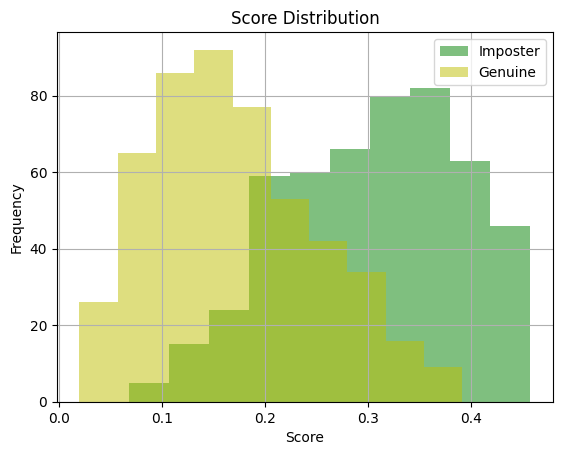

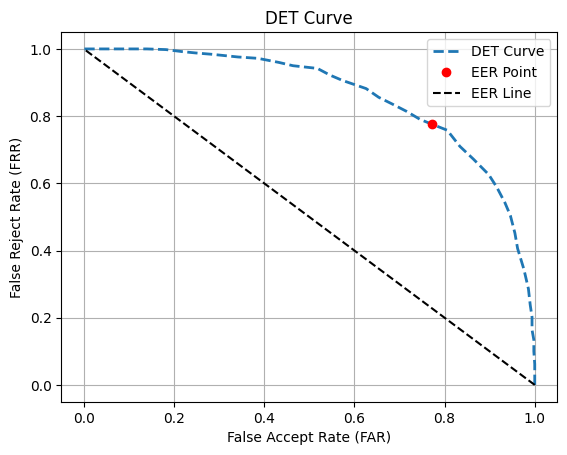

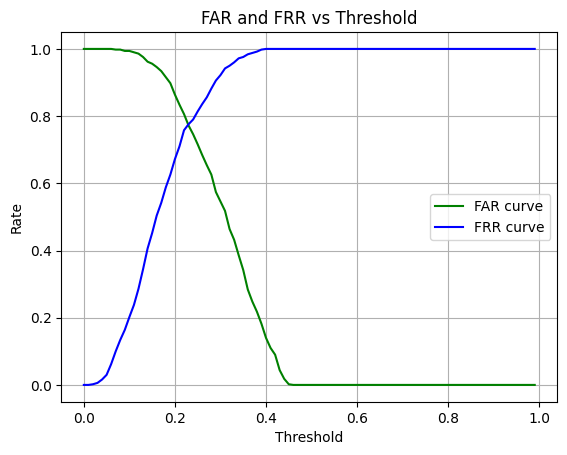

EER at threshold: 0.23
At threshold 0.23 accuracy score is 0.7740
EER at threshold: 0.23
At threshold 0.23 accuracy score is 0.7740


In [22]:
# Evaluate the Optimized CNN Model
pairs_df_cnn_opt, eer_info_cnn_opt, far_cnn_opt, frr_cnn_opt = evaluate_model(model_cnn_optimized)

print(f"EER at threshold: {eer_info_cnn_opt['err_threshold']}")
print(f"At threshold {eer_info_cnn_opt['err_threshold']} accuracy score is {eer_info_cnn_opt['accuracy']:.4f}")


In [24]:
# Collect EER and accuracy data
eer_data = {
    'Model': ['Linear Regression', 'DNN', 'CNN'],
    'EER Threshold': [eer_info_lr_opt['err_threshold'], eer_info_dnn_opt['err_threshold'], eer_info_cnn_opt['err_threshold']],
    'Accuracy at EER': [eer_info_lr_opt['accuracy'], eer_info_dnn_opt['accuracy'], eer_info_cnn_opt['accuracy']],
}

eer_df = pd.DataFrame(eer_data)
print(eer_df)


               Model  EER Threshold  Accuracy at EER
0  Linear Regression           0.05            0.638
1                DNN           0.05            0.614
2                CNN           0.23            0.774


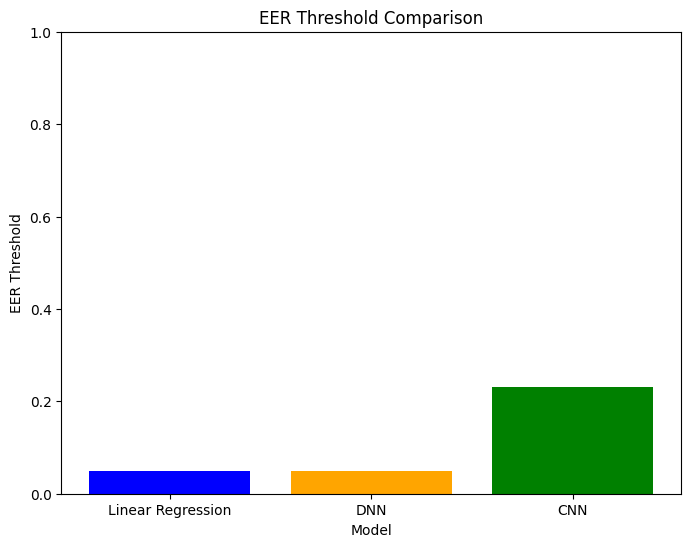

In [25]:
def plot_eer_thresholds(eer_df):
    plt.figure(figsize=(8, 6))
    plt.bar(eer_df['Model'], eer_df['EER Threshold'], color=['blue', 'orange', 'green'])
    plt.title('EER Threshold Comparison')
    plt.xlabel('Model')
    plt.ylabel('EER Threshold')
    plt.ylim(0, 1)
    plt.show()

# Plot EER Thresholds
plot_eer_thresholds(eer_df)


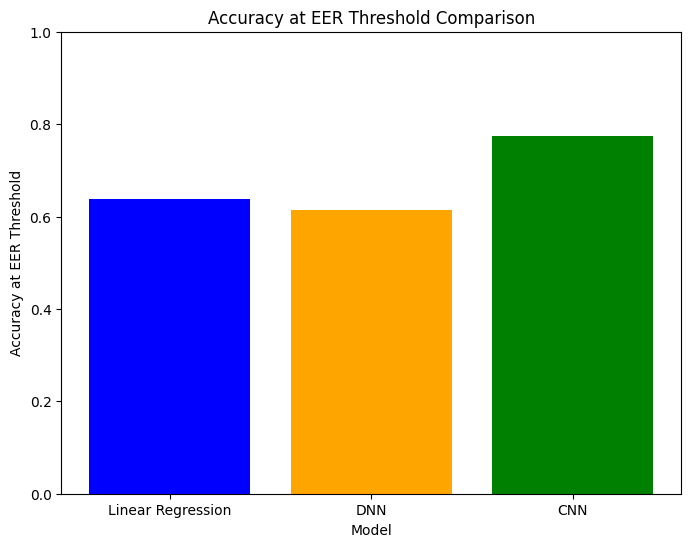

In [26]:
def plot_accuracy_at_eer(eer_df):
    plt.figure(figsize=(8, 6))
    plt.bar(eer_df['Model'], eer_df['Accuracy at EER'], color=['blue', 'orange', 'green'])
    plt.title('Accuracy at EER Threshold Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy at EER Threshold')
    plt.ylim(0, 1)
    plt.show()

# Plot Accuracy at EER Threshold
plot_accuracy_at_eer(eer_df)
